In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras import layers,Sequential,Input

import tensorflow_hub as hub

In [2]:
data_directory = pathlib.Path('/kaggle/input/for-image-classification-of-cheetah-vs-hyena/train')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(class_names)

['cheetah', 'hyena']


In [3]:
hyena_dir = '/kaggle/input/for-image-classification-of-cheetah-vs-hyena/train/hyena' 
cheeta_dir = '/kaggle/input/for-image-classification-of-cheetah-vs-hyena/train/cheetah'
data_dir = '/kaggle/input/for-image-classification-of-cheetah-vs-hyena/train'

In [4]:
num_hyena_images = len(os.listdir(hyena_dir))
num_cheeta_images = len(os.listdir(cheeta_dir))
print(f'Number of Dog images: {num_hyena_images}')
print(f'Number of Cat images: {num_cheeta_images}')

Number of Dog images: 900
Number of Cat images: 900


In [5]:
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 1440 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


In [6]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [7]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """
    
    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 10))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()       
    plt.show()

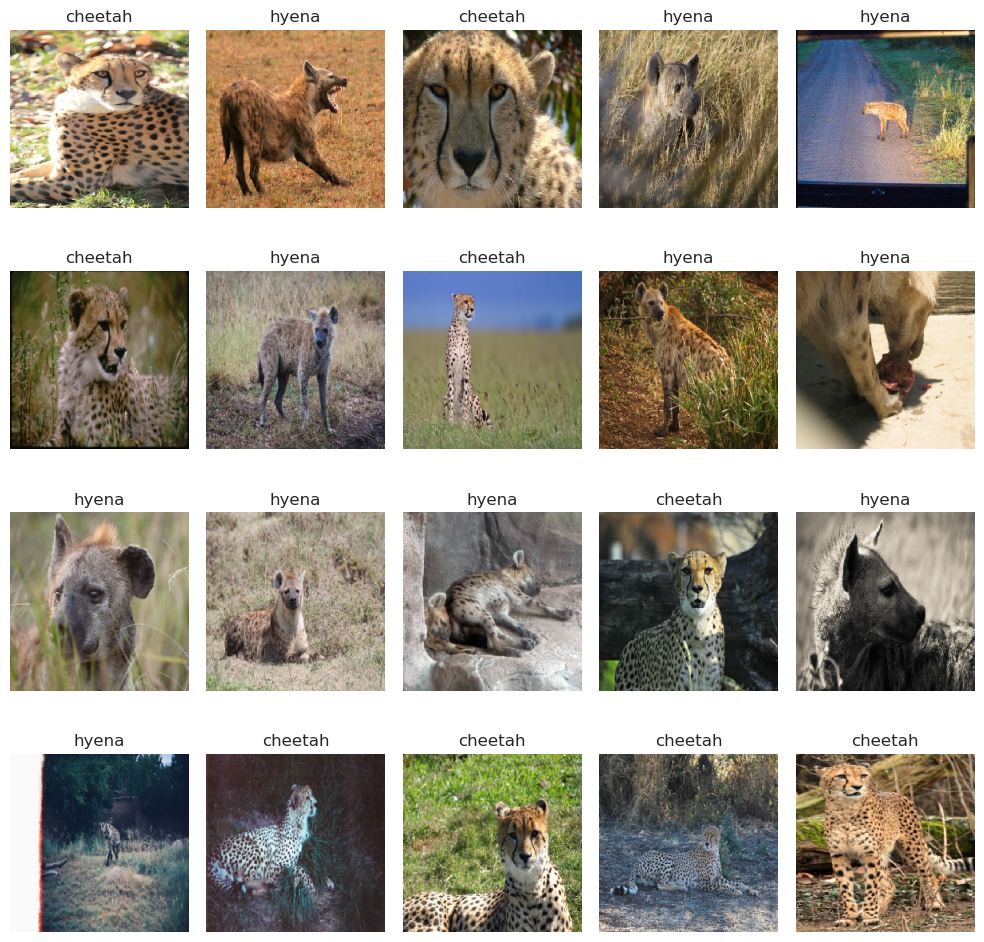

In [8]:
plot_random_images()

In [9]:
model = Sequential([
        Input(shape = images[0].shape),
        layers.Conv2D(34,(3,3),padding = "same",activation = "relu"),
        layers.MaxPooling2D((2,2),strides = 2),
        layers.Conv2D(64,(3,3),padding = "same",activation = "relu"),
        layers.MaxPooling2D((2,2),strides = 2),
        layers.Flatten(),
        layers.Dense(128,activation = "relu"),
        layers.Dense(2,activation = "softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 34)      952       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 34)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      19648     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [11]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [12]:
classifier = model.fit(train_data, batch_size = 32, 
                                 epochs = 12, 
                                 validation_data = val_data, 
                                 verbose = 1,
                                 callbacks = [reduce_lr])

Epoch 1/12
45/45 [==============================] - 25s 348ms/step - loss: 1.5168 - accuracy: 0.5847 - val_loss: 0.5618 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 2/12
45/45 [==============================] - 6s 128ms/step - loss: 0.4674 - accuracy: 0.7903 - val_loss: 0.4077 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 3/12
45/45 [==============================] - 6s 131ms/step - loss: 0.3410 - accuracy: 0.8562 - val_loss: 0.3327 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 4/12
45/45 [==============================] - 6s 129ms/step - loss: 0.2463 - accuracy: 0.8944 - val_loss: 0.3730 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 5/12
45/45 [==============================] - 6s 134ms/step - loss: 0.1657 - accuracy: 0.9382 - val_loss: 0.3123 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 6/12
45/45 [==============================] - 6s 130ms/step - loss: 0.0808 - accuracy: 0.9778 - val_loss: 0.3165 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/12
45/45 [==============================] - 8s 169ms/step - l

In [13]:
model.evaluate(val_data)

12/12 [==============================] - 1s 98ms/step - loss: 0.4206 - accuracy: 0.8889


[0.42058178782463074, 0.8888888955116272]

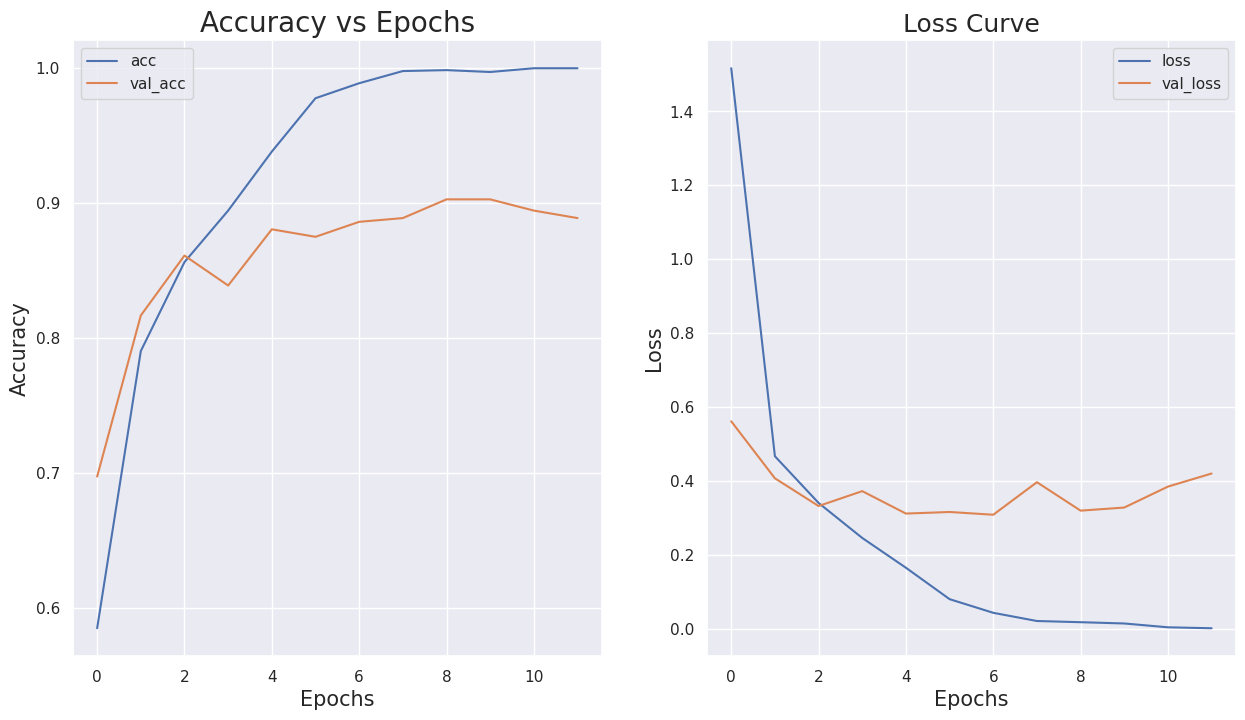

In [14]:
def model_performance_graphs():
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()
    
model_performance_graphs()

In [15]:
model.save('model.h5')

In [16]:
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5')

In [17]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0
    
    return img_preprocessed

In [18]:
img_path = "/kaggle/input/for-image-classification-of-cheetah-vs-hyena/train/cheetah/cheetah_006_resized.jpg"
img = preprocess_images(img_path)
prediction = loaded_model.predict(img)

predicted_class_index = np.argmax(prediction)

class_labels = [ 'Cheetah','Hyena']  
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

1/1 [==============================] - 0s 144ms/step
Predicted class: Cheetah
